In [1]:
from src.data_loader import PVDataLoader
from src import data_loader as dl
import torch
import numpy as np

In [4]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6
NUM_OUTPUTS = 1
NUM_LATENTS = 1
NUM_INDUCING = 100

In [28]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()

periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, minute_interval=MINUTE_INTERVAL)
periodic_train, _, periodic_test, _ = dl.train_test_split(periodic_time, y, n_hours=N_HOURS_PRED)

time = torch.arange(0, len(y))

t_train, y_train, t_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)

periodic_train *= y_train[:,:NUM_OUTPUTS].max()
periodic_test *= y_test[:,:NUM_OUTPUTS].max()

==> Loading data
==> Loaded data in: 0 m : 8 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



# Exact Latent Force Model

In [29]:
import gpytorch
import numpy as np
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt
from os import path

In [30]:
from gpytorch.constraints import Positive, Interval

PI = torch.tensor(np.pi, requires_grad=False)


class SIMKernel(gpytorch.kernels.Kernel):
    """
    Simple Input Module Motif Kernel
    This kernel is the multi-output cross-kernel for linear response to single transcription factor.
    In other words, it constructs a JTxJT matrix where J is num genes and T is num timepoints.
    SIM: Single Input Module motif
    """

    is_stationary = True

    def __init__(self, num_genes, variance, dtype=torch.float32, **kwargs):
        super().__init__(**kwargs)
        self.num_genes = num_genes
        # TODO fix constraints
        self.pos_constraint = Positive()
        self.lengthscale_constraint = Interval(0.1, 10)
        
        # TODO fix constraints
        self.register_parameter(
            name='raw_lengthscale', parameter=torch.nn.Parameter(
                self.lengthscale_constraint.inverse_transform(torch.ones(1, 1, dtype=dtype) ))
        )
        self.register_parameter(
            name='raw_decay', parameter=torch.nn.Parameter(
                self.pos_constraint.inverse_transform(0.4 * torch.ones(self.num_genes, dtype=dtype)))
        )
        self.register_parameter(
            name='raw_sensitivity', parameter=torch.nn.Parameter(
                self.pos_constraint.inverse_transform(1 * torch.ones(self.num_genes, dtype=dtype)))
        )
        self.register_parameter(
            name='raw_noise', parameter=torch.nn.Parameter(1 * torch.ones(self.num_genes, dtype=dtype))
        )

        # register the constraints
        self.register_constraint("raw_lengthscale", self.lengthscale_constraint)
        # self.register_constraint("raw_sensitivity", Positive())
        # self.register_constraint("raw_decay", Positive())
        # self.register_constraint("raw_noise", self.pos_constraint)

        self.variance = torch.diag(variance)

    @property
    def lengthscale(self):
        return self.lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        self.initialize(raw_lengthscale=self.lengthscale_constraint.inverse_transform(value))

    @property
    def decay(self):
        return self.pos_constraint.transform(self.raw_decay)

    @decay.setter
    def decay(self, value):
        self.initialize(raw_decay=self.pos_constraint.inverse_transform(value))

    @property
    def sensitivity(self):
        return self.pos_constraint.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.initialize(raw_sensitivity=self.pos_constraint.inverse_transform(value))

    @property
    def noise(self):
        return self.pos_constraint.transform(self.raw_noise)

    @noise.setter
    def noise(self, value):
        self.initialize(raw_noise=self.pos_constraint.inverse_transform(value))

    def plot_cov(self, x1, x2):
        from matplotlib import pyplot as plt
        Kxx = self(x1, x2)
        plt.figure()
        plt.imshow(Kxx.detach().evaluate().detach())
        plt.colorbar()
        return Kxx

    def forward(self, t1, t2, **params):
        """
        This calculates Kxx (not cross-covariance)
        t1, t2 are blocked timepoint vectors
        Parameters:
           x1 shape (num_genes*num_times)
        """
        vert_block_size = int(t1.shape[0] / self.num_genes)
        hori_block_size = int(t2.shape[0] / self.num_genes)
        t1_block, t2_block = t1[:vert_block_size], t2[:hori_block_size]
        shape = [vert_block_size * self.num_genes, hori_block_size * self.num_genes]
        K_xx = torch.zeros(shape, dtype=torch.float64)
        
        for j in range(self.num_genes):
            for k in range(self.num_genes):
                kxx = self.k_xx(j, k, t1_block, t2_block)
                K_xx[j * vert_block_size:(j + 1) * vert_block_size,
                     k * hori_block_size:(k + 1) * hori_block_size] = kxx

        if hori_block_size == vert_block_size:
            # noise = self.noise.view(-1, 1).repeat(1, hori_block_size).view(-1)
            # noise = torch.diag(noise)
            jitter = 1e-4 * torch.eye(K_xx.shape[0], dtype=torch.float64)
            K_xx += jitter
            if K_xx.shape[0] == self.variance.shape[0]:
                K_xx += self.variance

        return K_xx

    def k_xx(self, j, k, t1_block, t2_block):
        """
        k_xx(t, t')
        t2 = t'
        Parameters:
            t1_block: tensor shape (T1,)
            t2_block: tensor shape (T2,)
        """
        t1_block = t1_block.view(-1, 1)
        t2_block = t2_block.view(1, -1)
        mult = self.sensitivity[j] * self.sensitivity[k] * self.lengthscale * 0.5 * torch.sqrt(PI)
        k_xx = mult * (self.h(k, j, t2_block, t1_block) + self.h(j, k, t1_block, t2_block))

        return k_xx

    def h(self, k, j, t2, t1):
        
        l = self.lengthscale
        t_dist = t2 - t1
        multiplier = torch.exp(self.gamma(k) ** 2) / (self.decay[j] + self.decay[k])  # (1, 1)
      
        first_erf_term = torch.erf(t_dist / l - self.gamma(k)) + torch.erf(t1 / l + self.gamma(k))  # (T,T)
        second_erf_term = torch.erf(t2 / l - self.gamma(k)) + torch.erf(self.gamma(k))
      
        return multiplier * (torch.multiply(torch.exp(-self.decay[k] * t_dist), first_erf_term) - \
                             torch.multiply(torch.exp(-self.decay[k] * t2 - self.decay[j] * t1), second_erf_term))

    def gamma(self, k):
        return self.decay[k] * self.lengthscale / 2

    def K_xf(self, x, f):
        """
        K_xf
        Cross-covariance. Not optimised (not in marginal likelihood).
        Parameters:
            x: tensor (JT, JT) the blocked observation vector
            f: tensor (T*) the non-blocked f prediction timepoint vector
        """
        shape = [x.shape[0], f.shape[0]]
        K_xf = torch.zeros(shape, dtype=torch.float32)
        self.block_size = int(x.shape[0] / self.num_genes)  # 7
        t1_block, t2_block = x[:self.block_size].view(-1, 1), f.view(1, -1)
        
        for j in range(self.num_genes):
            kxf = self.k_xf(j, t1_block, t2_block)
            K_xf[j * self.block_size:(j + 1) * self.block_size] = kxf

        return K_xf

    def k_xf(self, j, x, t_f):
        l = self.lengthscale
        t_dist = x - t_f
        erf_term = torch.erf(t_dist / l - self.gamma(j)) + torch.erf(t_f / l + self.gamma(j))
        return self.sensitivity[j] * l * 0.5 * torch.sqrt(PI) * torch.exp(self.gamma(j) ** 2) * torch.exp(
            -self.decay[j] * t_dist) * erf_term

    def K_ff(self, x1, x2):
        """Returns the RBF kernel between latent TF"""
        x1 = x1.view(-1)
        x2 = x2.view(-1)
        
        sq_dist = torch.square(x1.view(-1, 1)-x2)
        sq_dist = torch.div(sq_dist, 2*self.lengthscale.view((-1, 1)))
      
        K = torch.exp(-sq_dist)
      
        if K.shape[0] == K.shape[1]:
            jitter = 1e-3 * torch.eye(x1.shape[0])
            K += jitter
        return K


In [41]:
from torch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel

from alfi.models.lfm import LFM
from alfi.means import SIMMean
from alfi.utilities.data import flatten_dataset
from alfi.datasets import LFMDataset


class ExactLFM(LFM, gpytorch.models.ExactGP):
    """
    An implementation of the single input motif from Lawrence et al., 2006.
    """
    def __init__(self, dataset: LFMDataset, variance):
        train_t, train_y = flatten_dataset(dataset)

        super().__init__(train_t, train_y, likelihood=gpytorch.likelihoods.GaussianLikelihood())

        self.num_outputs = dataset.num_outputs
     
        self.train_t = train_t
        self.train_y = train_y
       
        self.covar_module = SIMKernel(self.num_outputs, torch.tensor(variance, requires_grad=False))
        initial_basal = torch.mean(train_y.view(self.num_outputs, -1), dim=1) * self.covar_module.decay
        self.mean_module = SIMMean(self.covar_module, self.num_outputs, initial_basal)

    @property
    def decay_rate(self):
        return self.covar_module.decay

    @decay_rate.setter
    def decay_rate(self, val):
        self.covar_module.decay = val

    def forward(self, x):

        x.flatten()
        
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) 
        print(covar_x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def predict_m(self, pred_t, jitter=1e-3) -> torch.distributions.MultivariateNormal:
        """
        Predict outputs of the LFM
        :param pred_t: prediction times
        :param jitter:
        :return:
        """
        Kxx = self.covar_module(self.train_t, self.train_t)
        K_inv = torch.inverse(Kxx.evaluate())
        pred_t_blocked = pred_t.repeat(self.num_outputs)
        K_xxstar = self.covar_module(self.train_t, pred_t_blocked).evaluate()
        K_xstarx = torch.transpose(K_xxstar, 0, 1).type(torch.float64)
        K_xstarxK_inv = torch.matmul(K_xstarx, K_inv)
        KxstarxKinvY = torch.matmul(K_xstarxK_inv.double(), self.train_y.double())
        mean = KxstarxKinvY.view(self.num_outputs, pred_t.shape[0])

        K_xstarxstar = self.covar_module(pred_t_blocked, pred_t_blocked).evaluate()
        var = K_xstarxstar - torch.matmul(K_xstarxK_inv, torch.transpose(K_xstarx, 0, 1))
        var = torch.diagonal(var, dim1=0, dim2=1).view(self.num_outputs, pred_t.shape[0])
        mean = mean.transpose(0, 1)
        var = var.transpose(0, 1)
        var = torch.diag_embed(var)
        var += jitter * torch.eye(var.shape[-1])
 
        return MultivariateNormal(mean, var)

    def predict_f(self, pred_t, jitter=1e-5) -> MultivariateNormal:
        """
        Predict the latent function.

        :param pred_t: Prediction times
        :param jitter:
        :return:
        """
        Kxx = self.covar_module(self.train_t, self.train_t)
        K_inv = torch.inverse(Kxx.evaluate())

        Kxf = self.covar_module.K_xf(self.train_t, pred_t).type(torch.float64)
        KfxKxx = torch.matmul(torch.transpose(Kxf, 0, 1), K_inv)
        mean = torch.matmul(KfxKxx.double(), self.train_y.double()).view(-1).unsqueeze(0)

        #Kff-KfxKxxKxf
        Kff = self.covar_module.K_ff(pred_t, pred_t)  # (100, 500)
        var = Kff - torch.matmul(KfxKxx, Kxf)
        # var = torch.diagonal(var, dim1=0, dim2=1).view(-1)
        var = var.unsqueeze(0)
        # For some reason a full covariance is not PSD, for now just take the variance: (TODO)
        var = torch.diagonal(var, dim1=1, dim2=2)
        var = torch.diag_embed(var)
        var += jitter * torch.eye(var.shape[-1])

        batch_mvn = gpytorch.distributions.MultivariateNormal(mean, var)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

    def save(self, filepath):
        torch.save(self.state_dict(), filepath+'lfm.pt')

    @classmethod
    def load(cls,
             filepath,
             lfm_args=[], lfm_kwargs={}):
        lfm_state_dict = torch.load(filepath+'lfm.pt')
        lfm = cls(*lfm_args, **lfm_kwargs)
        lfm.load_state_dict(lfm_state_dict)
        return lfm


torch.Size([456])
torch.Size([456, 1])


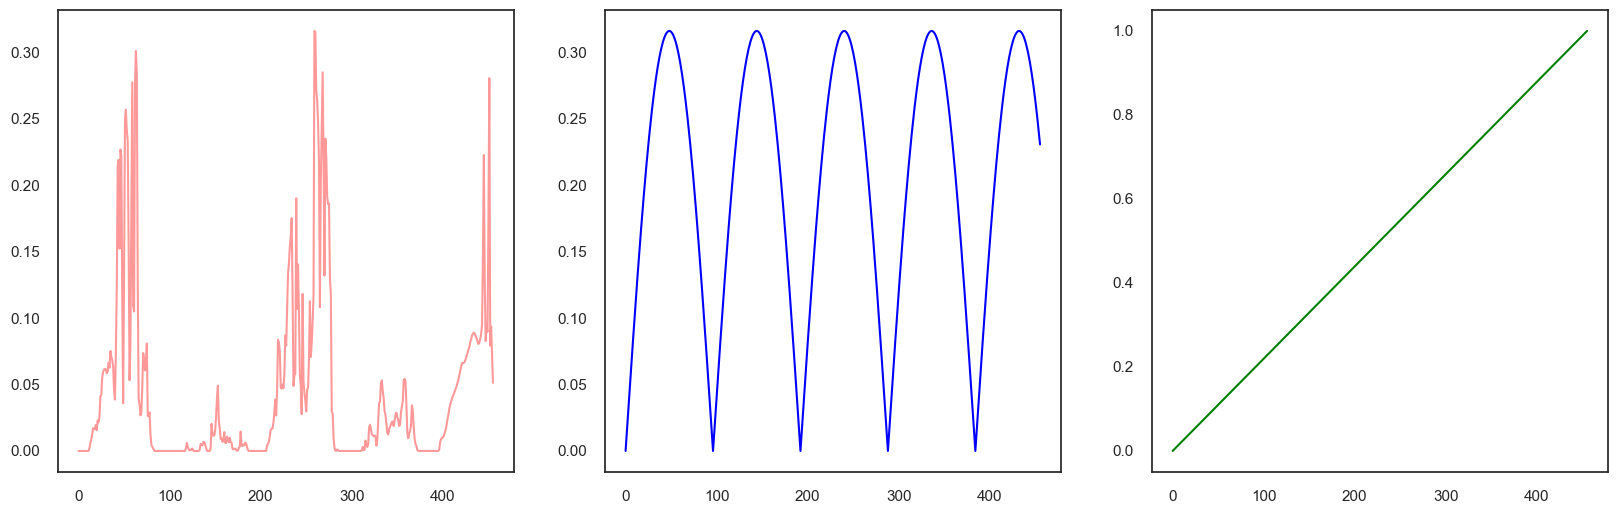

In [42]:
N_OBS = 1
m_observed = y_train[:, :N_OBS]
f_observed = periodic_train

print(f_observed.shape)
print(m_observed.shape)

# scale x_train to be between 0 and 1 and x_test to be between 1 and 2
t_train = torch.linspace(0, 1, len(x_train)) 
t_test = torch.linspace(1, (len(x_test) + len(x_train))/len(x_train), len(x_test))
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i in range(N_OBS):
    ax[0].plot(m_observed[:,i], color='red', alpha=0.4)

ax[1].plot(f_observed, color='blue')
ax[2].plot(t_train, color='green');
    

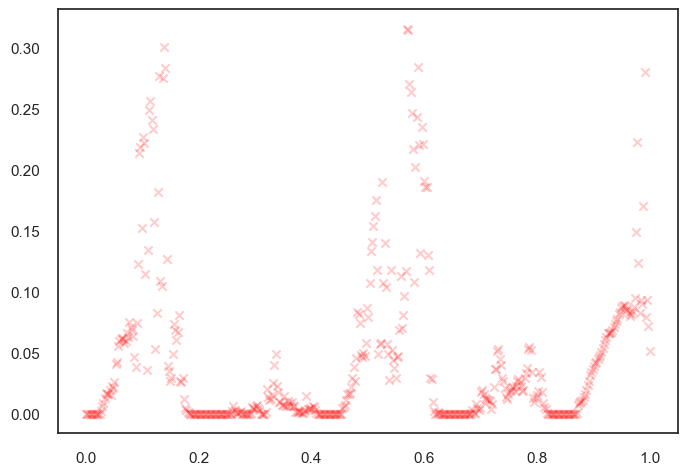

In [43]:
# create dataset
from lfm.dataset import PV_LFM_Dataset

dataset = PV_LFM_Dataset(N_OBS, m_observed, f_observed, t_train, 1*torch.ones(N_OBS) )
train_t, train_y = flatten_dataset(dataset)

train_t = train_t.view(-1, 1)
train_y = train_y.view(-1, 1)


plt.scatter(train_t, train_y, color='red', alpha=0.2, marker='x');

In [44]:
model = ExactLFM(dataset, dataset.variance.reshape(-1))                                                      
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model) 

/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_82499/1346456560.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.covar_module = SIMKernel(self.num_outputs, torch.tensor(variance, requires_grad=True))


In [45]:
from lfm.trainers import ExactTrainer

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]
trainer = ExactTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)
# trainer = ConstrainedTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)

model.likelihood.train()
a = trainer.train(epochs=100, report_interval=10)


Epoch 001/100 - Loss: 0.75 λ: [1.0852331]
Epoch 011/100 - Loss: 0.35 λ: [2.32952]
Epoch 021/100 - Loss: -0.11 λ: [3.751043]
Epoch 031/100 - Loss: -0.58 λ: [4.5895195]


/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.

In [89]:
t_predict_train = torch.linspace(t_train.min(), t_train.max(), len(t_train))
t_predict_test = torch.linspace(t_test.min(), t_test.max(), len(t_test))

p_m_train = model.predict_m(t_predict_train, jitter=1e-4)
p_f_train = model.predict_f(t_predict_train, jitter=1e-4)

p_m_test = model.predict_m(t_predict_test, jitter=1e-4)
p_f_test = model.predict_f(t_predict_test, jitter=1e-4)

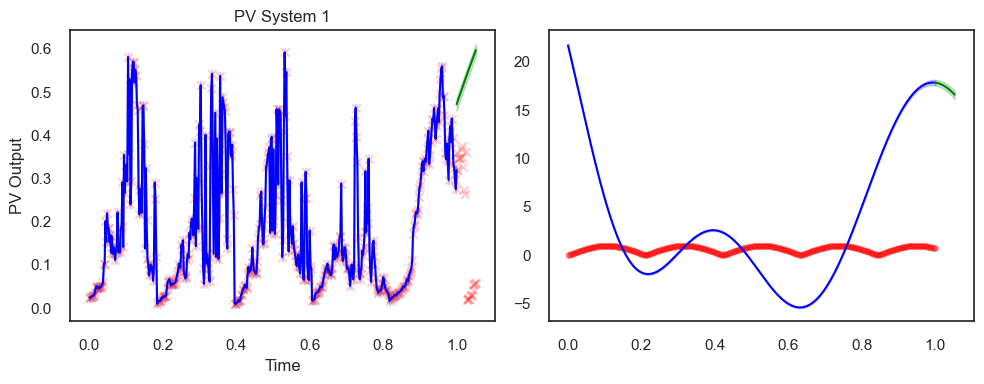

In [90]:
pv_mean_train = p_m_train.mean.detach().numpy().transpose(0, 1)
pv_std_train = p_m_train.variance.detach().sqrt().numpy().transpose(0, 1)

pv_mean_test = p_m_test.mean.detach().numpy().transpose(0, 1)
pv_std_test = p_m_test.variance.detach().sqrt().numpy().transpose(0, 1)

# remove the extra dimension from f
lf_mean_train = p_f_train.mean.detach().numpy().transpose(0, 1).squeeze()
lf_std_train = p_f_train.variance.detach().sqrt().numpy().transpose(0, 1).squeeze()

lf_mean_test = p_f_test.mean.detach().numpy().transpose(0, 1).squeeze()
lf_std_test = p_f_test.variance.detach().sqrt().numpy().transpose(0, 1).squeeze()


num_plots = pv_mean_train.shape[1]

if m_observed.shape[1] > 1:
   
    fig, axs = plt.subplots(num_plots, 2, figsize=(10, 10))
    for i in range(num_plots):
        for j in range(2):
            # plot pvs in first column and lfs in second column
            if j == 0:
                axs[i, j].plot(t_predict_train, pv_mean_train[:,i], color='blue')
                axs[i, j].fill_between(t_predict_train, pv_mean_train[:,i] - 2*pv_std_train[:,i], pv_mean_train[:,i] + 2*pv_std_train[:,i], color='blue', alpha=0.2)
                axs[i, j].plot(t_predict_test, pv_mean_test[:,i], color='green')
                axs[i, j].fill_between(t_predict_test, pv_mean_test[:,i] - 2*pv_std_test[:,i], pv_mean_test[:,i] + 2*pv_std_test[:,i], color='green', alpha=0.2)
                axs[i, j].scatter(t_train, y_train[:,i], color='red', alpha=0.2, marker='x')
                axs[i, j].scatter(t_test, y_test[:,i], color='red', alpha=0.2, marker='x')

                axs[i, j].set_title('PV System ' + str(i+1))
                axs[i, j].set_xlabel('Time')
                axs[i, j].set_ylabel('PV Output')
            else:
                axs[i, j].plot(t_predict_train, lf_mean_train, color='blue')
                axs[i, j].fill_between(t_predict_train, lf_mean_train - 2*lf_std_train, lf_mean_train + 2*lf_std_train, color='blue', alpha=0.2)
                axs[i, j].plot(t_predict_test, lf_mean_test, color='green')
                axs[i, j].fill_between(t_predict_test, lf_mean_test - 2*lf_std_test, lf_mean_test + 2*lf_std_test, color='green', alpha=0.2)
                axs[i, j].scatter(t_train, f_observed, color='red', alpha=0.2, marker='x')

    plt.tight_layout()
    plt.show()
else:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    # squeeze the extra dimension from all the arrays
    pv_mean_train = pv_mean_train.squeeze()
    pv_std_train = pv_std_train.squeeze()
    pv_mean_test = pv_mean_test.squeeze()
    pv_std_test = pv_std_test.squeeze()
    lf_mean_train = lf_mean_train.squeeze()
    lf_std_train = lf_std_train.squeeze()
    lf_mean_test = lf_mean_test.squeeze()
    lf_std_test = lf_std_test.squeeze()

    for j in range(2):
        # plot pvs in first column and lfs in second column
        if j == 0:
            axs[j].plot(t_predict_train, pv_mean_train, color='blue')
            axs[j].fill_between(t_predict_train, pv_mean_train - pv_std_train, pv_mean_train + pv_std_train, color='blue', alpha=0.2)
            axs[j].plot(t_predict_test, pv_mean_test, color='green')
            axs[j].fill_between(t_predict_test, pv_mean_test - pv_std_test, pv_mean_test + pv_std_test, color='green', alpha=0.2)
            axs[j].scatter(t_train, y_train[:,0], color='red', alpha=0.2, marker='x')
            axs[j].scatter(t_test, y_test[:,0], color='red', alpha=0.2, marker='x')

            axs[j].set_title('PV System ' + str(i+1))
            axs[j].set_xlabel('Time')
            axs[j].set_ylabel('PV Output')
        else:
            axs[j].plot(t_predict_train, lf_mean_train, color='blue')
            axs[j].fill_between(t_predict_train, lf_mean_train - lf_std_train, lf_mean_train + lf_std_train, color='blue', alpha=0.2)
            axs[j].plot(t_predict_test, lf_mean_test, color='green')
            axs[j].fill_between(t_predict_test, lf_mean_test - lf_std_test, lf_mean_test + lf_std_test, color='green', alpha=0.2)
            axs[j].scatter(t_train, f_observed, color='red', alpha=0.2, marker='o', s=15)

    plt.tight_layout()
    plt.show()